<a href="https://colab.research.google.com/github/UdaySMukherjee/GAN-CIFAR10/blob/main/CIFAR10_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd

# Path to the folder containing the images
images_folder = '/content/drive/MyDrive/dataset/train'

# Path to the CSV file containing the labels
labels_csv_file = '/content/drive/MyDrive/dataset/trainLabels.csv'

# Create a folder to store the sorted images
output_folder = '/content/drive/MyDrive/dataset/train'
os.makedirs(output_folder, exist_ok=True)

# Load the labels from the CSV file
labels_df = pd.read_csv(labels_csv_file)

# Find the index of the image with the specified photo number
start_photo_number = 37651
start_index = labels_df[labels_df['id'] == start_photo_number].index[0]

# Iterate through each image (starting from the specified photo number) and move it to the corresponding folder
for index, row in labels_df.iloc[start_index:].iterrows():
    image_id = row['id']
    label = row['label']

    # Create a folder for the label if it doesn't exist
    label_folder = os.path.join(output_folder, label)
    os.makedirs(label_folder, exist_ok=True)

    # Get the source path of the image
    source_image_path = os.path.join(images_folder, f'{image_id}.png')

    # Get the destination path of the image
    destination_image_path = os.path.join(label_folder, f'{image_id}.png')

    # Move the image to the corresponding label folder
    shutil.copyfile(source_image_path, destination_image_path)

print('Images sorted and saved successfully.')


Images sorted and saved successfully.


In [ ]:
# import modules
import os
import numpy as np
from numpy import zeros, ones, asarray
from numpy.random import randn, randint
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

In [ ]:
# define the discriminator model
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 8x8 image
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# load and prepare image data
def load_real_samples(dataset_path):
    images = []
    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # load and resize the image
            image = Image.open(os.path.join(dataset_path, filename))
            image = image.resize((32, 32))
            # convert PIL image to numpy array
            image = np.asarray(image)
            images.append(image)
    # normalize pixel values
    images = np.array(images)
    images = (images - 127.5) / 127.5
    return images

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
# create and show a plot of generated images
def show_plot(examples, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    n = int(np.sqrt(examples.shape[0]))
    plt.figure(figsize=(10, 10))
    for i in range(examples.shape[0]):
        # define subplot
        plt.subplot(n, n, i+1)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # display the plot
    plt.show()

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    n = int(np.sqrt(examples.shape[0]))
    plt.figure(figsize=(10, 10))
    for i in range(examples.shape[0]):
        # define subplot
        plt.subplot(n, n, i+1)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i])
    # display the plot
    plt.show()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # show plot
    show_plot(x_fake)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>Epoch %d, Batch %d/%d, d_loss1=%.3f, d_loss2=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

2/2 [==============================] - 1s 286ms/step
>Epoch 1, Batch 1/39, d_loss1=0.691, d_loss2=0.700, g_loss=0.687
2/2 [==============================] - 1s 272ms/step
>Epoch 1, Batch 2/39, d_loss1=0.510, d_loss2=0.773, g_loss=0.633
2/2 [==============================] - 1s 291ms/step
>Epoch 1, Batch 3/39, d_loss1=0.388, d_loss2=0.964, g_loss=0.578
2/2 [==============================] - 1s 285ms/step
>Epoch 1, Batch 4/39, d_loss1=0.294, d_loss2=1.018, g_loss=0.710
2/2 [==============================] - 1s 271ms/step
>Epoch 1, Batch 5/39, d_loss1=0.274, d_loss2=0.695, g_loss=1.115
2/2 [==============================] - 1s 284ms/step
>Epoch 1, Batch 6/39, d_loss1=0.283, d_loss2=0.528, g_loss=1.258
2/2 [==============================] - 1s 466ms/step
>Epoch 1, Batch 7/39, d_loss1=0.302, d_loss2=0.615, g_loss=0.913
2/2 [==============================] - 1s 281ms/step
>Epoch 1, Batch 8/39, d_loss1=0.334, d_loss2=0.861, g_loss=0.661
2/2 [==============================] - 1s 272ms/step
>Ep

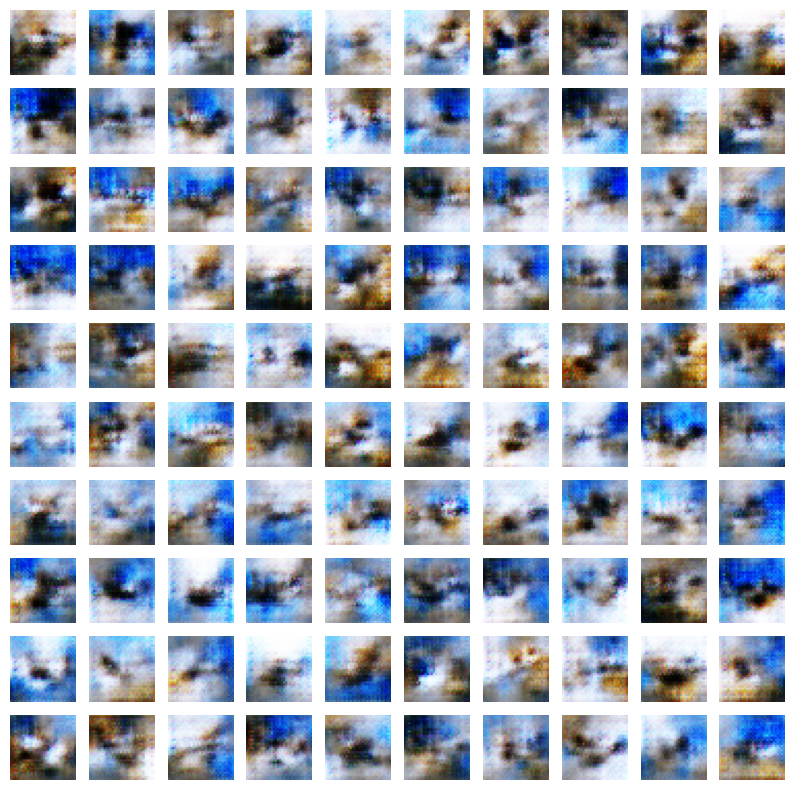

2/2 [==============================] - 1s 462ms/step
>Epoch 11, Batch 1/39, d_loss1=0.713, d_loss2=0.698, g_loss=0.706
2/2 [==============================] - 1s 279ms/step
>Epoch 11, Batch 2/39, d_loss1=0.717, d_loss2=0.691, g_loss=0.717
2/2 [==============================] - 1s 284ms/step
>Epoch 11, Batch 3/39, d_loss1=0.710, d_loss2=0.681, g_loss=0.720
2/2 [==============================] - 1s 488ms/step
>Epoch 11, Batch 4/39, d_loss1=0.716, d_loss2=0.680, g_loss=0.718
2/2 [==============================] - 1s 295ms/step
>Epoch 11, Batch 5/39, d_loss1=0.718, d_loss2=0.679, g_loss=0.722
2/2 [==============================] - 1s 277ms/step
>Epoch 11, Batch 6/39, d_loss1=0.715, d_loss2=0.688, g_loss=0.708
2/2 [==============================] - 1s 482ms/step
>Epoch 11, Batch 7/39, d_loss1=0.722, d_loss2=0.697, g_loss=0.704
2/2 [==============================] - 1s 282ms/step
>Epoch 11, Batch 8/39, d_loss1=0.727, d_loss2=0.703, g_loss=0.696
2/2 [==============================] - 1s 286ms/

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the GAN
gan_model = define_gan(g_model, d_model)

# load image data
dataset_path = "/content/drive/MyDrive/dataset/train/airplane"  # replace with your dataset path
dataset = load_real_samples(dataset_path)

# train the models
train(g_model, d_model, gan_model, dataset, latent_dim)

